In [17]:
## Implementation of handwritten digits using MNIST database.

# Import necessary modules
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torch.nn as nn

# Data training

# Data testing

In [51]:
# Hyperparameters for training
n_epochs = 6
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 100

random_seed = 1234
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [22]:
# Load MNIST dataset
mnist_dataset = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor() # normalize the pixel values to [0,1] by dividing 255
)

# Train dataset
train_loader = DataLoader(
    mnist_dataset,
    batch_size=batch_size_train,
    shuffle=True 
)

# Test dataset
test_loader = DataLoader(
    mnist_dataset,
    batch_size=batch_size_test,
    shuffle=True 
)

In [25]:
# Check out test data
check_test_data = enumerate(test_loader)
batch_idx, (t_data, t_targets) = next(check_test_data)
t_data.shape # [batch_size, channel(gray), pixel_x, pixel_y]

torch.Size([1000, 1, 28, 28])

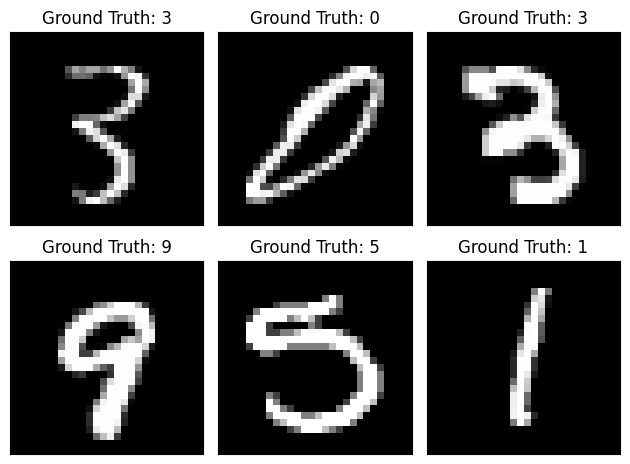

In [45]:
# Visualize data
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3, i+1)
    plt.imshow(t_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(t_targets[i]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    # plt.show()
# fig
plt.show()

In [69]:
# CNN architecture
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1,10, kernel_size=5)
        self.conv2 = nn.Conv2d(10,20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x= self.fc2(x)
        return F.log_softmax(x, dim=1)
        # return x

In [71]:
# Initialize network
network = Net()
#network.cuda() # for GPU-based training
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
# criterion = nn.CrossEntropyLoss()


In [72]:
# Traing the model

import os

# Directory to save models
results_dir = '/results'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i * len(train_loader.dataset) for i in range(n_epochs + 1)]

def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        # loss = criterion(output, target)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), '/results/model.pth')
            torch.save(optimizer.state_dict(), '/results/optimizer.pth')

In [76]:
# Test
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [77]:
# Run training
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()


Test set: Avg. loss: 0.0528, Accuracy: 59050/60000 (98%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.257956
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.275588
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.263501
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.192284
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.193214
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.132646
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.116310
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.291893
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.242273
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.067578

Test set: Avg. loss: 0.0522, Accuracy: 59053/60000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.044604
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.045518
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.113207
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.067684
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.136158
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.094702
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.193215
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.2

KeyboardInterrupt: 